In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to Python path
project_root = os.path.abspath("..")  # Adjust if needed
sys.path.insert(0, project_root)


In [2]:
from options.base_opts import TestOpts as Opts
from utils.logger import Logger
from datasets import Dataloader
from models import model_builder
from models import model_utils as mutil
from utils import eval_utils as eutil


In [3]:
# Simulate CLI arguments
sys.argv = [
    "notebook",
    "--data_dir_tst", "../SfPUEL_test_data/real1",
    "--suffix", "sfpuel_real1",
    "--cuda", "true",
    "--normal_pretrain", "../data/checkpoints/ckpt.pth"
]

# Parse arguments
args = Opts().parse()
args.local_rank = 0
args.device = torch.device(f'cuda:{args.local_rank}' if args.cuda else 'cpu')
Logger(args)

# Load model
model = model_builder.build_normal_model(args)
model.eval()
for p in model.parameters():
    p.requires_grad = False


Creating Normal Model [SfPUEL]
#### Pretrained Normal Model: ../data/checkpoints/ckpt.pth ####
=> Normal #Parameters : 166117137


In [4]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to Python path
project_root = os.path.abspath("..")  # Adjust if needed
sys.path.insert(0, project_root)


In [5]:
from options.base_opts import TestOpts as Opts
from utils.logger import Logger
from datasets import Dataloader
from models import model_builder
from models import model_utils as mutil
from utils import eval_utils as eutil


In [6]:
# Simulate CLI arguments
sys.argv = [
    "notebook",
    "--data_dir_tst", "../SfPUEL_test_data/real1",
    "--suffix", "sfpuel_real1",
    "--cuda", "true",
    "--normal_pretrain", "../data/checkpoints/ckpt.pth"
]

# Parse arguments
args = Opts().parse()
args.local_rank = 0
args.device = torch.device(f'cuda:{args.local_rank}' if args.cuda else 'cpu')
Logger(args)

# Load model
model = model_builder.build_normal_model(args)
model.eval()
for p in model.parameters():
    p.requires_grad = False


Creating Normal Model [SfPUEL]
#### Pretrained Normal Model: ../data/checkpoints/ckpt.pth ####
=> Normal #Parameters : 166117137


In [7]:
# Load one sample from test data
test_loader = Dataloader.loader_builder(args, args.normal_dataloader, args.split)
sample = next(iter(test_loader))

# Prepare input and run prediction
data = mutil.load_data(sample, args.device)
inputs = mutil.get_inputs(data, args.normal_branch_inputs)
with torch.no_grad():
    pred = model(inputs, args.decoder_resolution, args.canonical_resolution, args.pixel_samples)


=> fetching test data in ../SfPUEL_test_data/real1
Found Data:	 29 Test & Test Batch: 1 
	 Test Batch: 1


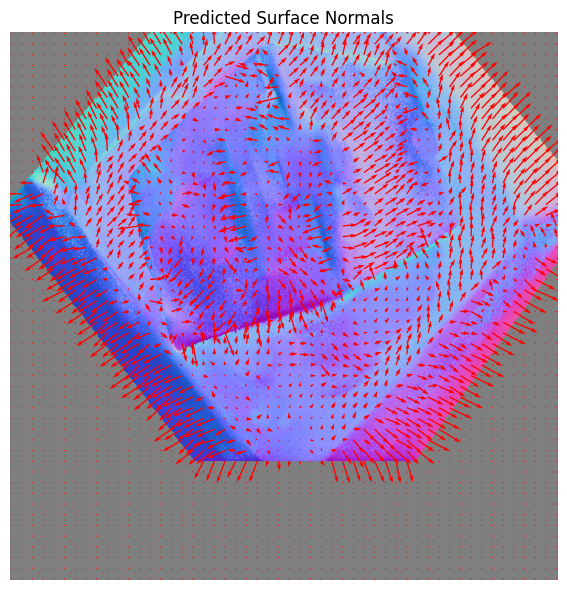

In [8]:
# Extract normal map
normal_tensor = pred['normal'][0].detach().cpu().numpy()  # [3, H, W]
nx, ny, nz = normal_tensor[0], normal_tensor[1], normal_tensor[2]
H, W = nx.shape

# Convert to RGB
normal_rgb = np.stack([(nx + 1) / 2, (ny + 1) / 2, (nz + 1) / 2], axis=2).clip(0, 1)

# Sample vector field
k = 10
y_coords = np.arange(0, H, k)
x_coords = np.arange(0, W, k)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
x_grid = x_grid.astype(np.float32) + 0.5
y_grid = y_grid.astype(np.float32) + 0.5

u = nx[y_coords[:, None], x_coords]
v = ny[y_coords[:, None], x_coords]

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(normal_rgb, origin='upper')  # or 'lower' if you want (0,0) at bottom
plt.quiver(x_grid, y_grid, u, v, color='red', scale=20, headwidth=3)
plt.axis('off')
plt.title("Predicted Surface Normals")
plt.tight_layout()
plt.show()


In [13]:
# Load one specific sample from test data
test_loader = Dataloader.loader_builder(args, args.normal_dataloader, args.split)

# Specify the object you want to visualize
target_name = 'beads'  # ← change this to the name you want

# Search for the matching sample
for sample in test_loader:
    data = mutil.load_data(sample, args.device)
    if data['name'][0] == target_name:
        print(f"✅ Found and loaded: {data['name'][0]}")
        break
else:
    raise ValueError(f"❌ Could not find object named: {target_name}")

# Prepare input and run prediction
inputs = mutil.get_inputs(data, args.normal_branch_inputs)
with torch.no_grad():
    pred = model(inputs, args.decoder_resolution, args.canonical_resolution, args.pixel_samples)


=> fetching test data in ../SfPUEL_test_data/real1
Found Data:	 29 Test & Test Batch: 1 
	 Test Batch: 1
✅ Found and loaded: beads


In [14]:
all_names = []
for sample in test_loader:
    name = sample['name'][0]
    all_names.append(name)

print("Available objects:", sorted(set(all_names)))


Available objects: ['anglebracket', 'anglebracket2', 'ball_green', 'ballblack', 'beads', 'beads1', 'beanball', 'bird', 'coin_500yen', 'coin_500yen2', 'dog_tag1', 'dog_tag4', 'dog_tag5', 'fish', 'fish2', 'green_bottle', 'kettle', 'lego_clear', 'lunchtoy', 'medicine1', 'necklace', 'owlblue', 'pdms_airtag2', 'pineapple', 'rooster', 'screws', 'silicone_extru1', 'siliconestrip_ball', 'teapot']


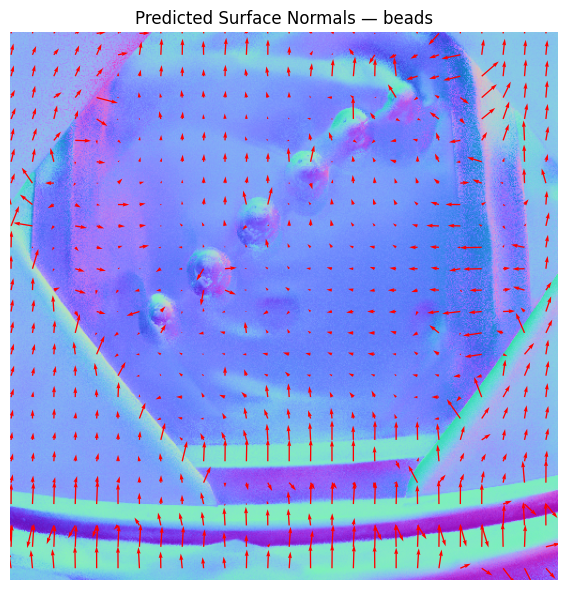

In [15]:
from PIL import Image

# Get the image name from data['name']
object_name = data['name'][0]
unpolar_path = f"../SfPUEL_test_data/real1/unpolar/{object_name}.png"

# Load the image using PIL and convert to normalized RGB
unpolar_img = Image.open(unpolar_path).convert("RGB")
bg_rgb = np.asarray(unpolar_img).astype(np.float32) / 255.0

# Extract normal map
normal_tensor = pred['normal'][0].detach().cpu().numpy()  # [3, H, W]
nx, ny, nz = normal_tensor[0], normal_tensor[1], normal_tensor[2]
H, W = nx.shape

# Convert to RGB
normal_rgb = np.stack([(nx + 1) / 2, (ny + 1) / 2, (nz + 1) / 2], axis=2).clip(0, 1)

# Sample vector field
k = 20      # Sampling interval
y_coords = np.arange(0, H, k)
x_coords = np.arange(0, W, k)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
x_grid = x_grid.astype(np.float32) + 0.5
y_grid = y_grid.astype(np.float32) + 0.5

u = nx[y_coords[:, None], x_coords]
v = ny[y_coords[:, None], x_coords]

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(normal_rgb, origin='upper')  # or 'lower' if you want (0,0) at bottom
plt.quiver(x_grid, y_grid, u, v, color='red', scale=20, headwidth=3)
plt.axis('off')
plt.title(f"Predicted Surface Normals — {data['name'][0]}")
plt.tight_layout()
plt.show()


Loop and Plot All Surface Normals (normal map background)

In [12]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
save_dir = "../results/arrows"
os.makedirs(save_dir, exist_ok=True)

# Reset dataloader
test_loader = Dataloader.loader_builder(args, args.normal_dataloader, args.split)

seen = set()

for sample in tqdm(test_loader, desc="Saving arrow plots"):
    data = mutil.load_data(sample, args.device)
    name = data['name'][0]

    if name in seen:
        continue
    seen.add(name)

    # Run model
    inputs = mutil.get_inputs(data, args.normal_branch_inputs)
    with torch.no_grad():
        pred = model(inputs, args.decoder_resolution, args.canonical_resolution, args.pixel_samples)

    # Extract normal map
    normal_tensor = pred['normal'][0].detach().cpu().numpy()
    nx, ny, nz = normal_tensor[0], normal_tensor[1], normal_tensor[2]
    H, W = nx.shape
    normal_rgb = np.stack([(nx + 1) / 2, (ny + 1) / 2, (nz + 1) / 2], axis=2).clip(0, 1)

    # Quiver grid
    k = 20
    y_coords = np.arange(0, H, k)
    x_coords = np.arange(0, W, k)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    x_grid = x_grid.astype(np.float32) + 0.5
    y_grid = y_grid.astype(np.float32) + 0.5
    u = nx[y_coords[:, None], x_coords]
    v = ny[y_coords[:, None], x_coords]

    # Plot + Save
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(normal_rgb, origin='upper')
    ax.quiver(x_grid, y_grid, u, v, color='red', scale=20, headwidth=3)
    ax.axis('off')
    ax.set_title(f"{name}")
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, f"{name}.png"), dpi=150)
    plt.close(fig)  # prevent display in notebook


=> fetching test data in ../SfPUEL_test_data/real1
Found Data:	 29 Test & Test Batch: 1 
	 Test Batch: 1


Saving arrow plots: 100%|██████████| 29/29 [00:28<00:00,  1.03it/s]
